In [4]:
#| hide
from nbdev.showdoc import *
from allos.color_palette import ghibli
import os
import requests
import gzip
import shutil

# Transcript plots
> The TranscriptPlots class is defined to facilitate the visualization of transcript structures.

The class can be initialized with GTF and FASTA files (optional but recommended for further analysis with Transcript Data module). If provided, it creates an instance of TranscriptData.

Methods:
- get_transcript_info: Retrieves detailed information about a specified transcript, including its ID, name, type, coding sequence (CDS) start and end positions, chromosome, and strand orientation.
- draw_transcripts_list: Public method to draw a list of transcripts with optional color customization.
- draw_transcripts_list_unscaled: Similar to draw_transcripts_list but plots transcripts without scaling their intron lengths proportionally to their genomic lengths, useful for transcipts with extremely long introns

In [ ]:
#| default_exp transcript_plots

In [31]:
#| export
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt

In [3]:

from allos.transcript_data import TranscriptData

In [4]:
import os
import urllib.request
from pathlib import Path

Exons: +--------------+----------------+------------+-----------+-------+
|   Chromosome | Source         | Feature    |     Start | +22   |
|   (category) | (object)       | (object)   |   (int64) | ...   |
|--------------+----------------+------------+-----------+-------|
|            1 | ensembl_havana | exon       |   3740774 | ...   |
|            1 | ensembl_havana | exon       |   3491924 | ...   |
|            1 | ensembl_havana | exon       |   3284704 | ...   |
+--------------+----------------+------------+-----------+-------+
Stranded PyRanges object has 3 rows and 26 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
22 hidden columns: End, Score, Strand, Frame, gene_id, gene_version, ... (+ 16 more.)


In [ ]:
from allos.transcript_data import TranscriptData

In [110]:
# | export
class TranscriptPlots:
    def __init__(self, gtf_file=None, reference_fasta=None):
        self.transcript_data = None
        if gtf_file is not None:
            from allos.transcript_data import TranscriptData
            self.transcript_data = TranscriptData(gtf_file=gtf_file, reference_fasta=reference_fasta)

    def get_transcript_info(self, transcript_id):
        if self.transcript_data is None:
            raise NotImplementedError()

        data_dict = dict()
        keys = ['transcript_id', 'transcript_name', 'transcript_type', 'cds_start', 'cds_end', 'chromosome', 'strand']
        for key in keys:
            data_dict[key] = 0
        data_dict['cds_end'] = -sys.maxsize
        data_dict['cds_start'] = sys.maxsize
        cds = self.transcript_data.get_cds(transcript_id)
        df = cds.df.sort_values(by="Start")
        for _, row in df.iterrows():
            data_dict['transcript_id'] = row["transcript_id"]
            data_dict['transcript_name'] = row["transcript_name"]
            data_dict['transcript_type'] = row["transcript_type"] if 'transcript_type' in row else "unknown"
            data_dict['cds_start'] = min(row["Start"], data_dict['cds_start'])
            data_dict['cds_end'] = max(row["Start"], data_dict['cds_end'])
            data_dict['chromosome'] = row["Chromosome"]
            data_dict['strand'] = row["Strand"]

        return data_dict
    
    def _get_coord_from_tscrpt_id(self, transcript_id):
        if self.transcript_data is None:
            if '.' in transcript_id:
                transcript_id = transcript_id.split('.')[0]
            server = "https://rest.ensembl.org"
            ext = "/lookup/id/" + transcript_id + "?expand=1"

            r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})

            if not r.ok:
                r.raise_for_status()
                sys.exit()

            decoded = r.json()
            exon_list = list(decoded['Exon'])
            exon_coord = []
            for i, e in enumerate(exon_list):
                coord = [e.get('end'), e.get('start')]
                exon_coord.append(coord)
            strand = decoded['strand']
            return(exon_coord, strand)
        else:
            return self.transcript_data.get_exon_coords_and_strand(transcript_id)

    def _draw_transcript(self, exons, direction, color, transcript_name, offset=0, start_override=None, end_override=None, no_render=False, with_cds=False):
        if not no_render:
            plt.axes()
            plt.xlim((-0.1, 1))
            plt.ylim((-0.3, 0.3))
            plt.margins(0.2)
            plt.axis('off')
            fig = plt.gcf()
            fig.set_size_inches(20, 2)
        height = 0.2
        cds_start, cds_end = 0, 0
        # plt.plot([offset + 0.1, offset + 0.1], linestyle='solid', linewidth=0.5, c='grey')
        j = 0
        k = 1
        if direction == 1:
            pos_start = exons[0][1]
            pos_end = exons[-1][0]
        else: #direction == -1
            pos_start = exons[-1][1]
            pos_end = exons[0][0]
            j = 1
            k = 0
        real_start = pos_start
        real_end = pos_end
        if with_cds:
            t_info = self.get_transcript_info(transcript_name)
            cds_start, cds_end = t_info['cds_start'], t_info['cds_end']
        if start_override is not None and end_override is not None:
            pos_start = start_override
            pos_end = end_override
        total_length = pos_end - pos_start
        total_length_with_margin = 1.05 * total_length
        pos_start_with_margin = pos_start - 0.025*total_length
         # Draw introns as separate lines
        for i in range(len(exons) - 1):
            intron_start = exons[i][j]
            intron_end = exons[i + 1][k]
            plt.plot([(intron_start - pos_start_with_margin)/total_length_with_margin, (intron_end - pos_start_with_margin)/total_length_with_margin], [offset + 0.1, offset + 0.1], color='black', linestyle='-', linewidth=1)
        for i, exon in enumerate(exons):
            edgecolor= 'black'
            if exon[j] <= cds_end and exon[k] >= cds_start:
                edgecolor = 'red'  # Make CDS more visible
                color = 'red'
            rectangle = plt.Rectangle(((exon[j] - pos_start_with_margin)/total_length_with_margin,offset), (exon[k] - exon[j])/total_length_with_margin, height, fc=color,ec="black",edgecolor=edgecolor)
            plt.gca().add_patch(rectangle)
        if i > 0:
            arrow = None
            if direction < 0:
                arrow = plt.arrow(1, offset - height/4, -1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
            else:
                arrow = plt.arrow(0, offset - height/4, 1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
            plt.gca().add_patch(arrow)
        plt.plot(np.array([0.025 + (real_start - pos_start) / (total_length)/1.05, 0.025 + (real_start - pos_start) / (total_length)/1.05]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
        plt.plot(np.array([1 - 0.025 - (pos_end - real_end) / (total_length)/1.05, 1 - 0.025 - (pos_end - real_end) / (total_length)/1.05]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
        plt.text(0.025 + (real_start - pos_start) / (total_length)/1.05, offset - height/4 - 0.075, real_start, horizontalalignment='center', verticalalignment='center', fontsize=9)
        plt.text(1 - 0.025 - (pos_end - real_end) / (total_length)/1.05, offset - height/4 - 0.075, real_end, horizontalalignment='center', verticalalignment='center', fontsize=9)
        plt.text(1, offset - height, transcript_name, horizontalalignment='right', verticalalignment='top', fontsize=12)
        if not no_render:
            plt.show()

    def _draw_transcripts_list(self, trs_to_show, _ax, colors=None, draw_cds=False):
        transcripts_id = trs_to_show
        exons = []
        directions = []
        for tr in transcripts_id:
            t, d = self._get_coord_from_tscrpt_id(tr)
            exons += [t]
            directions += [d]
        if colors is None:
            colors = []
            for i in range(len(exons)):
                colors.append(self.colors[i % len(self.colors)])
        def get_limits(ex, dir):
            start = sys.maxsize
            end = -sys.maxsize
            for (e, d) in zip(ex, dir):
                if d == 1:
                    start = min(start,e[0][1])
                    end = max(end, e[-1][0])
                else:
                    start = min(start,e[-1][1])
                    end = max(end, e[0][0])
            return (start, end)
        plt.axes()
        plt.xlim((-0.1, 1.1))
        plt.ylim((0.1 - 0.5 *  len(exons), 0.3))
        plt.margins(0.2)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(20, len(exons) * 2)
        i = 0
        (start, end) = get_limits(exons, directions)
        for (ex, di, co, name) in zip(exons, directions, colors, transcripts_id):
            self._draw_transcript(ex, di, co, name, offset= -0.5 * i, start_override=start, end_override=end, no_render=True, with_cds=draw_cds)
            i+=1
        if _ax is None:
            plt.show()
        else:
            return plt

    def draw_transcripts_list(self, transcripts_ids, colors=None, draw_cds=False):
        if draw_cds and self.transcript_data is None:
            raise Exception('A GTF file is compulsory in order to display the CDS region')
        self._draw_transcripts_list(transcripts_ids, None, colors, draw_cds=draw_cds)

    def draw_transcripts_list_unscaled(self, transcripts_id, colors=None):
        exons = []
        directions = []
        for tr in transcripts_id:
            t, d = self._get_coord_from_tscrpt_id(tr)
            exons += [t]
            directions += [d]
        if colors is None:
            colors = []
            for i in range(len(exons)):
                colors.append(self.colors[i % len(self.colors)])
        def get_limits(ex, dir):
            start = sys.maxsize
            end = -sys.maxsize
            for (e, d) in zip(ex, dir):
                if d == 1:
                    start = min(start,e[0][1])
                    end = max(end, e[-1][0])
                else:
                    start = min(start,e[-1][1])
                    end = max(end, e[0][0])
            return (start, end)

        def move_exons(exons_list, direction, max_width, min_width):
            i = 1
            if direction == 1:
                while i < len(exons_list):
                    if exons_list[i][1] - exons_list[i - 1][0] < min_width:
                        diff = min_width - (exons_list[i][1] - exons_list[i - 1][0])
                        exons_list[i][0] += diff
                        exons_list[i][1] += diff
                    elif exons_list[i][1] - exons_list[i - 1][0] > max_width:
                        diff = (exons_list[i][1] - exons_list[i - 1][0]) - max_width
                        exons_list[i][0] -= diff
                        exons_list[i][1] -= diff
                    i += 1
            else:
                while i < len(exons_list):
                    if exons_list[i][0] - exons_list[i - 1][1] < min_width:
                        diff = min_width - (exons_list[i][0] - exons_list[i - 1][1])
                        exons_list[i][1] += diff
                        exons_list[i][0] += diff
                    elif exons_list[i][0] - exons_list[i - 1][1] > max_width:
                        diff = (exons_list[i][0] - exons_list[i - 1][1]) - max_width
                        exons_list[i][1] -= diff
                        exons_list[i][0] -= diff
                    i += 1
            return exons_list
        plt.axes()
        plt.xlim((-0.1, 1.1))
        plt.ylim((0.1 - 0.5 *  len(exons), 0.3))
        plt.margins(0.2)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(20, len(exons) * 2)
        i = 0
        fake_exons = []
        fake_se = []
        for exon_list, direction in zip(exons, directions):
            fake_exon = []
            (start, end) = get_limits([exon_list], [direction])
            full_length = end - start
            max_width = full_length / (len(exon_list) - 2 if len(exon_list) > 2 else 1)
            min_width = full_length / (10 * (len(exon_list) + 5))
            max_width_e = full_length / 2
            min_width_e = full_length / 20
            for exon in exon_list:
                fake_exon_start = 0
                fake_exon_end = 0
                if direction == 1:
                    fake_exon_start = exon[1]
                    if (exon[0] - exon[1]) > max_width:
                        fake_exon_end = exon[1] + max_width
                    elif (exon[0] - exon[1]) < min_width:
                        fake_exon_end = exon[1] + min_width
                    else:
                        fake_exon_end = exon[0]
                    fake_exon.append([fake_exon_end, fake_exon_start])
                else:
                    fake_exon_start = exon[0]
                    if (exon[1] - exon[0]) > max_width:
                        fake_exon_end = exon[0] + max_width
                    elif (exon[1] - exon[0]) < min_width:
                        fake_exon_end = exon[0] + min_width
                    else:
                        fake_exon_end = exon[1]
                    fake_exon.append([fake_exon_start, fake_exon_end])
            fake_exon = move_exons(fake_exon, direction, max_width_e, min_width_e)
            fake_exons.append(fake_exon)
            (fake_s, fake_e) = get_limits([fake_exon], [direction])
            fake_se.append([fake_s, fake_e])
        for (ex, di, co, name) in zip(fake_exons, directions, colors, transcripts_id):
            self._draw_transcript(ex, di, co, name, offset= -0.5 * i, start_override=fake_se[i][0], end_override=fake_se[i][1], no_render=True)
            i+=1
        plt.show()


To initialise class:

In [111]:
tp = TranscriptPlots(gtf_file="/data/analysis/data_diamant/allos/allos/data/custom_subset.gtf")

In [85]:
#| hide
from allos.color_palette import ghibli

In [100]:
tp.get_transcript_info('ENSMUST00000107851')

{'transcript_id': 'ENSMUST00000107851',
 'transcript_name': 'Clta-205',
 'transcript_type': 'unknown',
 'cds_start': 44012791,
 'cds_end': 44032400,
 'chromosome': '4',
 'strand': '+'}

To plot a panel for one or several transcripts:

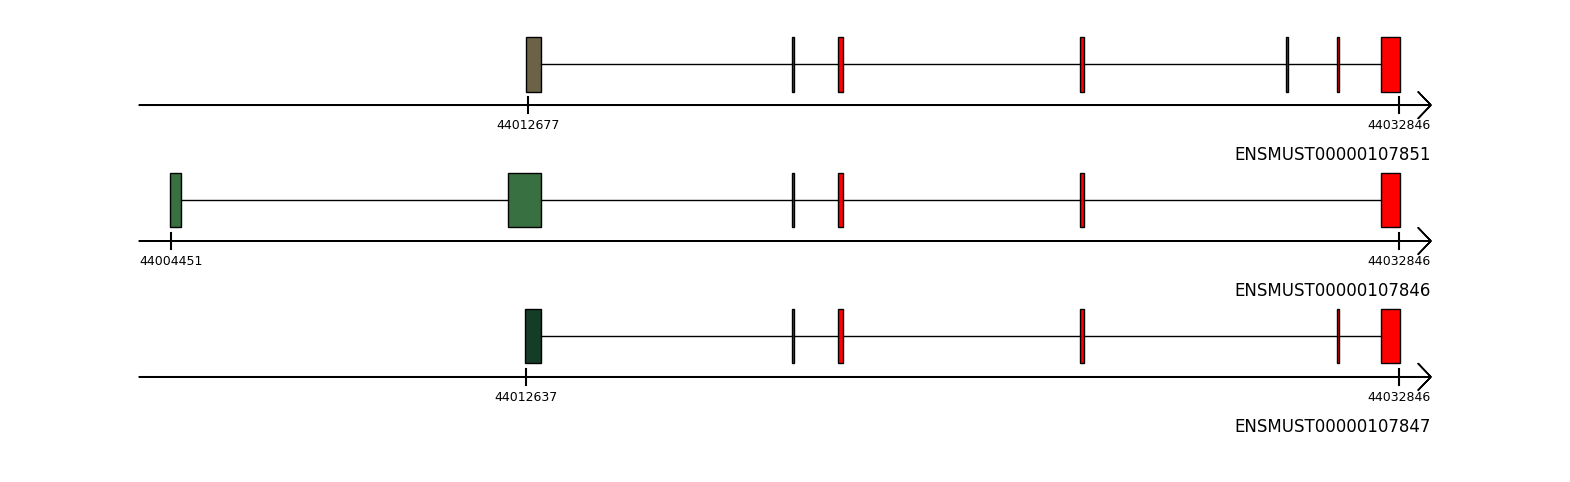

In [112]:
tp.draw_transcripts_list(["ENSMUST00000107851", "ENSMUST00000107846", "ENSMUST00000107847"], colors=ghibli, draw_cds=True)


get_transcript_info helps to retrieve information about the transcripts of interest:

In [109]:
import pandas as pd  

transcripts = ["ENSMUST00000107851", "ENSMUST00000107846", "ENSMUST00000107847"]
transcripts_info = []

for i in transcripts:
    transcripts_info.append(tp.get_transcript_info(i))  # Append transcript info to list

df = pd.DataFrame(transcripts_info)  # Convert list of dictionaries to DataFrame
print(df)  # Display the DataFrame

        transcript_id transcript_name transcript_type  cds_start   cds_end  \
0  ENSMUST00000107851        Clta-205         unknown   44012791  44032400   
1  ENSMUST00000107846        Clta-202         unknown   44012791  44032400   
2  ENSMUST00000107847        Clta-203         unknown   44012791  44032400   

  chromosome strand  
0          4      +  
1          4      +  
2          4      +  


"draw_transcript_list_unscaled" keeps the structure of transcripts but shortens the introns. It is useful to compare the structure of
transcipts with extremely long introns:

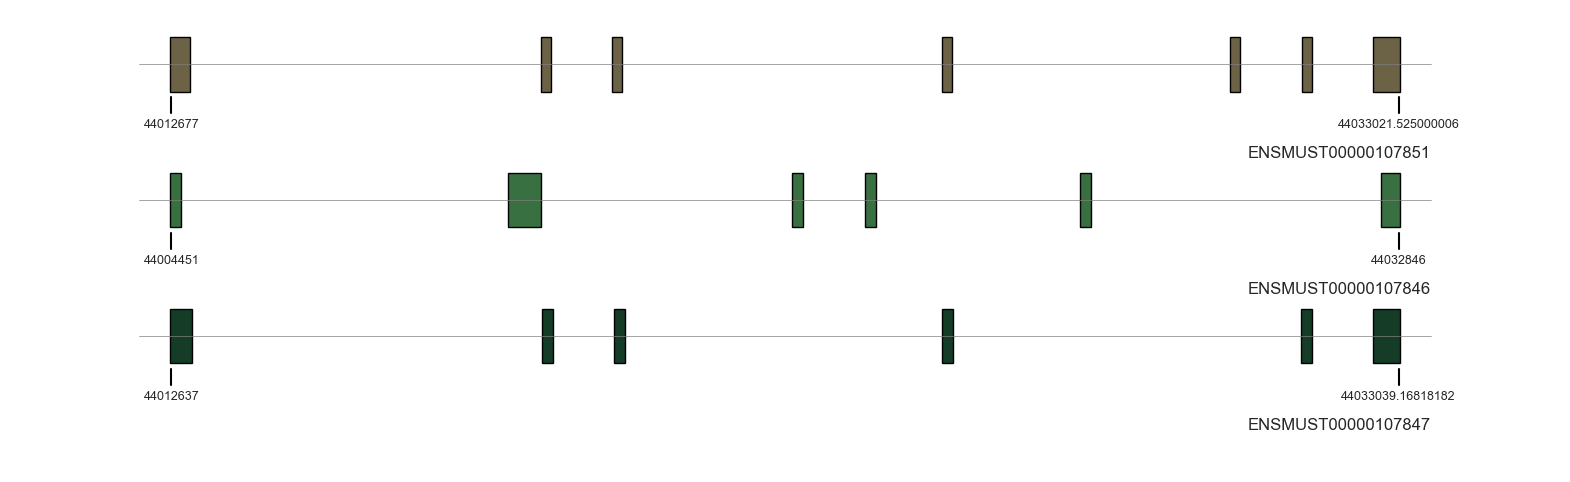

In [ ]:
tp.draw_transcripts_list_unscaled(["ENSMUST00000107851", "ENSMUST00000107846", "ENSMUST00000107847"], colors=ghibli)

If neither gtf nor fasta is provided, the transcripts can be provided as ensembl id and the coordinates will be fetched from ensembl api.

In [13]:
#cage_peaks = "https://fantom.gsc.riken.jp/5/datafiles/reprocessed/mm10_latest/extra/CAGE_peaks/mm10_fair+new_CAGE_peaks_phase1and2.bed.gz"
cage_peaks = "https://reftss.riken.jp/datafiles/current/mouse/refTSS_v4.1_mouse_coordinate.mm39.bed.gz"

In [5]:
def download_and_extract_bed(url, local_folder):
    """
    Downloads and extracts a BED file from a given URL if it doesn't already exist.
    
    Parameters:
    - url (str): The URL of the `.bed.gz` file to download.
    - local_folder (str): The folder where the file should be saved.
    
    Returns:
    - str: Path to the extracted BED file.
    """
    # Ensure local folder exists
    os.makedirs(local_folder, exist_ok=True)

    # Extract filename from URL
    filename = os.path.basename(url)
    compressed_file = os.path.join(local_folder, filename)
    extracted_file = compressed_file.replace(".gz", "")

    # Check if extracted file already exists
    if os.path.exists(extracted_file):
        print(f"Extracted BED file already exists: {extracted_file}")
        return extracted_file

    # Download if necessary
    if not os.path.exists(compressed_file):
        print(f"Downloading {compressed_file}...")
        response = requests.get(url, stream=True)
        with open(compressed_file, "wb") as f:
            shutil.copyfileobj(response.raw, f)
        print("Download complete.")

    # Extract the file
    print(f"Extracting {compressed_file}...")
    with gzip.open(compressed_file, "rb") as f_in, open(extracted_file, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    print(f"Extraction complete: {extracted_file}")

    return extracted_file

In [14]:
cage_peaks = download_and_extract_bed(cage_peaks, "../data/")

Download complete.
Extracting ../data/refTSS_v4.1_mouse_coordinate.mm39.bed.gz...
Extraction complete: ../data/refTSS_v4.1_mouse_coordinate.mm39.bed


In [20]:
import pandas as pd
#col_names = ["chrom", "start", "end", "name", "score", "strand"]
cage_df = pd.read_csv(cage_peaks, sep="\t", comment='#')

In [21]:
cage_df

,chromosome,start,end,refTSS_ID,score,strand
0,chr1,3221101,3221109,rfmm_1.1,1,+
1,chr1,3226272,3226277,rfmm_2.1,1,+
2,chr1,3389727,3389730,rfmm_3.1,1,-
3,chr1,3448009,3448012,rfmm_4.1,1,-
4,chr1,3559372,3559376,rfmm_5.1,1,-
...,...,...,...,...,...,...
172319,chrY,90831164,90831167,rfmm_172320.1,1,+
172320,chrY,90831173,90831188,rfmm_172321.1,1,+
172321,chrY,90831968,90831970,rfmm_172322.1,1,+
172322,chrY,90836575,90836577,rfmm_172323.1,1,-


In [113]:
# find the tss that overlap with the gene coordinates:
# get the coordinates of plot transcript panel, find the tss coordinates 
# that are inside these limits (pos_end, pos_start in _draw_transcript):


In [94]:
def extract_genes_from_gtf(gtf_gz_path, output_gtf, gene_ids):
    """
    Extracts specified genes from a GTF file inside a .gz archive and writes a new GTF file.

    Parameters:
    - gtf_gz_path (str): Path to the original GTF .gz file.
    - output_gtf (str): Path for the new GTF file.
    - gene_ids (list): List of gene IDs to extract (e.g., ["ENSMUSG00000025902", "ENSMUSG00000025903"]).
    """
    extracted_gtf_path = gtf_gz_path.rstrip(".gz")  # Remove .gz extension for the extracted file

    # Check if extracted file already exists
    from pathlib import Path
    if not Path(extracted_gtf_path).exists():
        print(f"🔄 Extracting {gtf_gz_path}...")
        with gzip.open(gtf_gz_path, "rt") as gz_file, open(extracted_gtf_path, "w") as out_file:
            shutil.copyfileobj(gz_file, out_file)
        print(f"✅ Extracted: {extracted_gtf_path}")
    else:
        print(f"📂 Using existing extracted file: {extracted_gtf_path}")

    # Read the extracted GTF file, skipping comment lines
    gtf = pd.read_csv(extracted_gtf_path, sep="\t", comment='#', header=None, dtype=str)

    # GTF column names based on Ensembl/Gencode format
    gtf.columns = [
        "seqname", "source", "feature", "start", "end", "score",
        "strand", "frame", "attribute"
    ]

    # Extract gene IDs from the 'attribute' column
    def get_gene_id(attribute):
        for entry in attribute.split(";"):
            entry = entry.strip()
            if entry.startswith("gene_id"):
                return entry.split(" ")[1].strip('"')
        return None

    # Filter GTF for the selected genes
    gtf["gene_id"] = gtf["attribute"].apply(get_gene_id)
    filtered_gtf = gtf[gtf["gene_id"].isin(gene_ids)].drop(columns=["gene_id"])

    # Save to new GTF file
    filtered_gtf.to_csv(output_gtf, sep="\t", index=False, header=False, quoting=3)

    print(f"✅ Extracted {len(filtered_gtf)} entries for {len(gene_ids)} genes into {output_gtf}")


In [98]:
big_gtf = "/data/analysis/data_diamant/allos/allos/data/Mus_musculus.GRCm39.109.gtf"
custom_gtf = "/data/analysis/data_diamant/allos/allos/data/custom_subset.gtf"
selected_genes = ["ENSMUSG00000028478", "ENSMUSG00000025903"]  # Replace with your genes of interest

extract_genes_from_gtf(big_gtf, custom_gtf, selected_genes)


📂 Using existing extracted file: /data/analysis/data_diamant/allos/allos/data/Mus_musculus.GRCm39.109.gtf
✅ Extracted 250 entries for 2 genes into /data/analysis/data_diamant/allos/allos/data/custom_subset.gtf


In [119]:
from allos.transcript_data import TranscriptData
td = TranscriptData(gtf_file="/data/analysis/data_diamant/allos/allos/data/custom_subset.gtf")

In [121]:
td

In [122]:
td.get_exon_coords_and_strand("ENSMUSG00000028478")

([], None)

In [150]:
import pyranges as pr

def get_gene_coordinates_from_gtf(gtf_path, transcript_id):
    """Extracts chromosome, start, and end coordinates of a gene from a GTF file using transcript ID."""
    
    # Load GTF file as pyranges object
    gtf = pr.read_gtf(gtf_path)
    
    # Check available columns
    print("Available columns in GTF:", gtf.columns)

    # Ensure the transcript ID column exists
    if "transcript_id" not in gtf.columns:
        raise ValueError("Column 'transcript_id' not found in GTF. Check column names.")

    # Find the gene associated with the given transcript ID
    transcript_info = gtf[gtf.transcript_id == transcript_id]  # Use the correct column name

    if transcript_info.empty:
        raise ValueError(f"Transcript '{transcript_id}' not found in GTF file.")

    # Get gene ID associated with the transcript
    gene_id = transcript_info.gene_id.iloc[0]  # Ensure correct column name
    
    # Extract gene coordinates
    gene_info = gtf[gtf.gene_id == gene_id]  # Ensure correct column name

    chromosome = gene_info.Chromosome.iloc[0]
    start = gene_info.Start.min()
    end = gene_info.End.max()

    return {"gene_id": gene_id, "chromosome": chromosome, "start": start, "end": end}


def find_tss_in_gene_range(cage_peaks_df, gene_coordinates):
    """Finds CAGE TSS peaks that overlap with the gene coordinates."""
    # Ensure chromosome formats match between gene_coordinates and cage_peaks_df
    gene_chr = gene_coordinates["chromosome"]
    cage_chr = cage_peaks_df["chromosome"].unique()

    # Check if gene_chr starts with "chr"
    if not gene_chr.startswith("chr"):
        gene_coordinates["chromosome"] = f"chr{gene_chr}"

    # Check if cage_peaks_df chromosomes start with "chr"
    if any(not c.startswith("chr") for c in cage_chr):
        cage_peaks_df["chromosome"] = cage_peaks_df["chromosome"].apply(lambda x: f"chr{x}" if not x.startswith("chr") else x)

    print("✅ Chromosome formats are now consistent!")
    # Filter peaks that are in the same chromosome
    peaks_in_chromosome = cage_peaks_df[cage_peaks_df["chromosome"] == gene_coordinates["chromosome"]]

    # Ensure coordinates are integers
    gene_start = int(gene_coordinates["start"])
    gene_end = int(gene_coordinates["end"])

    peaks_in_chromosome["start"] = peaks_in_chromosome["start"].astype(int)
    peaks_in_chromosome["end"] = peaks_in_chromosome["end"].astype(int)

    # Filter peaks that overlap the gene range
    overlapping_peaks = peaks_in_chromosome[
        (peaks_in_chromosome["start"] >= gene_coordinates["start"]) &
        (peaks_in_chromosome["end"] <= gene_coordinates["end"])
    ]

    return overlapping_peaks

In [151]:
# Example Usage
gtf_path = "/data/analysis/data_diamant/allos/allos/data/custom_subset.gtf"
transcript_id = "ENSMUST00000134384"
gene_coordinates = get_gene_coordinates_from_gtf(gtf_path, "ENSMUST00000134384")
print("Extracted Gene Coordinates:", gene_coordinates)

Available columns in GTF: Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source',
       'gene_biotype', 'transcript_id', 'transcript_version',
       'transcript_name', 'transcript_source', 'transcript_biotype',
       'transcript_support_level', 'exon_number', 'exon_id', 'exon_version',
       'protein_id', 'protein_version', 'tag', 'ccds_id'],
      dtype='object')
Extracted Gene Coordinates: {'gene_id': 'ENSMUSG00000025903', 'chromosome': '1', 'start': 4878010, 'end': 4918633}


In [152]:
cage_peaks_path = "/data/analysis/data_diamant/allos/allos/data/refTSS_v4.1_mouse_coordinate.mm39.bed"
# Load CAGE peaks as a dataframe
cage_peaks_df = pd.read_csv(cage_peaks_path, sep="\t", names=["chromosome", "start", "end", "refTSS_ID", "score", "strand"])

# Get gene coordinates from GTF
gene_coordinates = get_gene_coordinates_from_gtf(gtf_path, transcript_id)


Available columns in GTF: Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source',
       'gene_biotype', 'transcript_id', 'transcript_version',
       'transcript_name', 'transcript_source', 'transcript_biotype',
       'transcript_support_level', 'exon_number', 'exon_id', 'exon_version',
       'protein_id', 'protein_version', 'tag', 'ccds_id'],
      dtype='object')


/tmp/ipykernel_3974226/2903875487.py:3: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  cage_peaks_df = pd.read_csv(cage_peaks_path, sep="\t", names=["chromosome", "start", "end", "refTSS_ID", "score", "strand"])


In [153]:
gene_coordinates

{'gene_id': 'ENSMUSG00000025903',
 'chromosome': '1',
 'start': 4878010,
 'end': 4918633}

In [154]:
find_tss_in_gene_range(cage_peaks_df, gene_coordinates)

✅ Chromosome formats are now consistent!


/tmp/ipykernel_3974226/1431948614.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_in_chromosome["start"] = peaks_in_chromosome["start"].astype(int)
/tmp/ipykernel_3974226/1431948614.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_in_chromosome["end"] = peaks_in_chromosome["end"].astype(int)


,chromosome,start,end,refTSS_ID,score,strand
38,chr1,4878070,4878151,rfmm_38.1,1,+
39,chr1,4878469,4878510,rfmm_39.1,1,+
40,chr1,4898798,4898839,rfmm_40.1,1,+
41,chr1,4915816,4915827,rfmm_41.1,1,+
